##### CNN-RNN

In [1]:
import tensorflow as tf
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Embedding, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from numpy import unique
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix

In [2]:
test = pd.read_csv("../Datasets/FA-KESDataset/FA-KES-Dataset.csv")
test.columns
test.head()

,unit_id,article_title,article_content,source,date,location,labels,URL
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0,http://nna-leb.gov.lb/en/show-news/77705/
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0,http://nna-leb.gov.lb/en/show-news/77731/nna-l...
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0,http://nna-leb.gov.lb/en/show-news/29474/nna-l...
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0,http://nna-leb.gov.lb/en/show-news/78274/nna-l...
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0,http://nna-leb.gov.lb/en/show-news/65189/nna-l...


In [3]:
test['labels'].value_counts()

1    426
0    378
Name: labels, dtype: int64

<AxesSubplot:xlabel='labels', ylabel='count'>

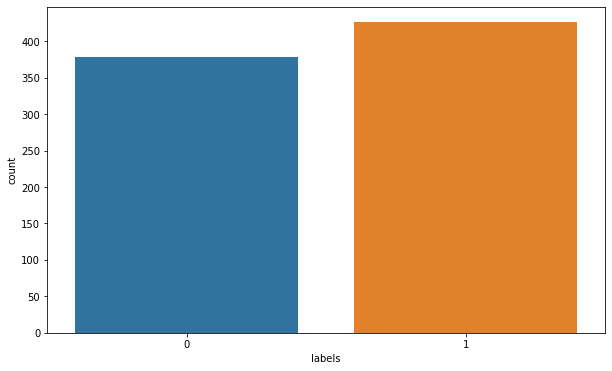

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(x='labels', data=test)

In [5]:
test['article_content'] = test['article_content'].apply(lambda x: str(x).lower())

In [6]:
test = test[['article_content', 'labels']]

In [7]:
test['labels'] = test['labels'].astype(float)

In [8]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to c:\users\bliu0\appdata\local\temp\pip-req-build-trnohvs6
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7691 sha256=ffafa87fd57e7a332ea2511f2f0b68fe537baaf6dc6553a8bd4c8ec0a8457225
  Stored in directory: C:\Users\bliu0\AppData\Local\Temp\pip-ephem-wheel-cache-uddcb7vw\wheels\cd\26\af\103cfac199bd773bfc95ed85a52fe9095e4d902ed9ac3b0c97
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git 'C:\Users\bliu0\AppData\Local\Temp\pip-req-build-trnohvs6'


In [9]:
import preprocess_kgptalkie as ps

In [10]:
test['article_content'] = test['article_content'].apply(lambda x: ps.remove_special_chars(x))

In [11]:
x = [d.split() for d in test['article_content'].tolist()]
y = test['labels'].values

In [12]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [13]:
print(len(x))

804


In [14]:
DIM = 400
w2v_model = gensim.models.Word2Vec(sentences=x, vector_size=DIM, window=10, min_count=1)

In [15]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(x)

In [16]:
x = tokenizer.texts_to_sequences(x)

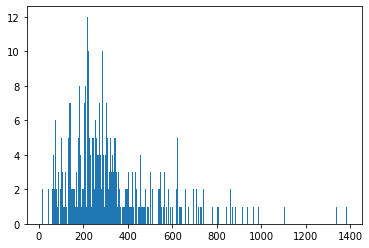

In [17]:
plt.hist([len(a) for a in x], bins = 700)
plt.show()

In [18]:
nos = np.array([len(a) for a in x])
len(nos[nos>1000])

4

In [19]:
maxlen = 100
x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=maxlen)

In [20]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [21]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items():
        try:
            weight_matrix[i] = model.wv[word]
        except:
            print("whatever")
        
    return weight_matrix

In [22]:
embedding_vectors = get_weight_matrix(w2v_model)

In [23]:
embedding_vectors.shape

(11008, 400)

In [24]:
maxlen

100

In [25]:
model = Sequential()

model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable = False))
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid")) 
model.add(LSTM(32))
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
    optimizer = "Adam",               
              metrics = ['accuracy', 'Recall', 'Precision', 'TrueNegatives', 'TruePositives', 'FalsePositives', 'FalseNegatives'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 400)          4403200   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           256128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dense (Dense)              

In [26]:
len(x)

804

In [27]:
CNNRNNX_train, CNNRNNX_test, CNNRNNy_train, CNNRNNy_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [28]:
CNNRNNy_train = np.array(CNNRNNy_train)
CNNRNNy_test = np.array(CNNRNNy_test)

In [172]:
model.fit(CNNRNNX_train, CNNRNNy_train, epochs=100, batch_size=64)

Train on 643 samples
Epoch 1/100
643/643 [==============================] - 1s 909us/sample - loss: 0.0672 - acc: 0.9518 - recall: 0.9496 - precision: 0.9581 - true_negatives: 292.0000 - true_positives: 320.0000 - false_positives: 14.0000 - false_negatives: 17.0000
Epoch 2/100
643/643 [==============================] - 1s 920us/sample - loss: 0.0643 - acc: 0.9642 - recall: 0.9763 - precision: 0.9564 - true_negatives: 291.0000 - true_positives: 329.0000 - false_positives: 15.0000 - false_negatives: 8.0000
Epoch 3/100
643/643 [==============================] - 1s 904us/sample - loss: 0.0807 - acc: 0.9611 - recall: 0.9436 - precision: 0.9815 - true_negatives: 300.0000 - true_positives: 318.0000 - false_positives: 6.0000 - false_negatives: 19.0000
Epoch 4/100
643/643 [==============================] - 1s 898us/sample - loss: 0.0829 - acc: 0.9627 - recall: 0.9525 - precision: 0.9757 - true_negatives: 298.0000 - true_positives: 321.0000 - false_positives: 8.0000 - false_negatives: 16.0000
Ep

In [30]:
model.evaluate(CNNRNNX_test, CNNRNNy_test)

161/161 [==============================] - 0s 1ms/sample - loss: 0.6931 - acc: 0.5528 - recall: 1.0000 - precision: 0.5528 - true_negatives: 0.0000e+00 - true_positives: 89.0000 - false_positives: 72.0000 - false_negatives: 0.0000e+00


[0.6930855605172814, 0.55279505, 1.0, 0.55279505, 0.0, 89.0, 72.0, 0.0]

# URL Classifier

In [31]:
!pip install whois
!pip install pyquery
!pip install tqdm
!pip install interruptingcow
!pip install requests

In [32]:
import requests
from interruptingcow import timeout
import whois
from datetime import datetime, timezone
import math
import pandas as pd
import numpy as np
from pyquery import PyQuery
from requests import get
import tensorflow as tf
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Embedding, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from numpy import unique
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [33]:
class UrlFeaturizer(object):
    def __init__(self, url):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now().replace(tzinfo=None)

        try:
            self.whois = whois.query(self.domain).__dict__
        except:
            self.whois = None

        try:
            self.response = get(self.url)
            self.pq = PyQuery(self.response.text)
        except:
            self.response = None
            self.pq = None

    ## URL string Features
    def entropy(self):
        string = self.url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

    def ip(self):
        string = self.url
        flag = False
        if ("." in string):
            elements_array = string.strip().split(".")
            if(len(elements_array) == 4):
                for i in elements_array:
                    if (i.isnumeric() and int(i)>=0 and int(i)<=255):
                        flag=True
                    else:
                        flag=False
                        break
        if flag:
            return 1 
        else:
            return 0

    def numDigits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def urlLength(self):
        return len(self.url)

    def numParameters(self):
        params = self.url.split('&')
        return len(params) - 1

    def numFragments(self):
        fragments = self.url.split('#')
        return len(fragments) - 1

    def numSubDomains(self):
        subdomains = self.url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

    def domainExtension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext

    ## URL domain features
    def hasHttp(self):
        return 'http:' in self.url

    def hasHttps(self):
        return 'https:' in self.url

    def daysSinceRegistration(self):
        if self.whois and self.whois['creation_date']:
            diff = self.today - self.whois['creation_date'].replace(tzinfo=None)
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    def daysSinceExpiration(self):
        if self.whois and self.whois['expiration_date']:
            diff = self.whois['expiration_date'].replace(tzinfo=None) - self.today
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0
    
     ## URL Page Features
    def bodyLength(self):
        if self.pq is not None:
            return len(self.pq('html').text()) if self.urlIsLive else 0
        else:
            return 0

    def numTitles(self):
        if self.pq is not None:
            titles = ['h{}'.format(i) for i in range(7)]
            titles = [self.pq(i).items() for i in titles]
            return len([item for s in titles for item in s])
        else:
            return 0

    def numImages(self):
        if self.pq is not None:
            return len([i for i in self.pq('img').items()])
        else:
            return 0

    def numLinks(self):
        if self.pq is not None:
            return len([i for i in self.pq('a').items()])
        else:
            return 0

    def scriptLength(self):
        if self.pq is not None:
            return len(self.pq('script').text())
        else:
            return 0

    def specialCharacters(self):
        if self.pq is not None:
            bodyText = self.pq('html').text()
            schars = [i for i in bodyText if not i.isdigit() and not i.isalpha()]
            return len(schars)
        else:
            return 0

    def scriptToSpecialCharsRatio(self):
        v = self.specialCharacters()
        if self.pq is not None and v!=0:
            sscr = self.scriptLength()/v
        else:
            sscr = 0
        return sscr

    def scriptTobodyRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            sbr = self.scriptLength()/v
        else:
            sbr = 0
        return sbr

    def bodyToSpecialCharRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            bscr = self.specialCharacters()/v
        else:
            bscr = 0
        return bscr

    def urlIsLive(self):
        return self.response == 200

    def run(self):
        data = {}
        data['entropy'] = self.entropy()
        data['numDigits'] = self.numDigits()
        data['urlLength'] = self.urlLength()
        data['numParams'] = self.numParameters()
        data['hasHttp'] = self.hasHttp()
        data['hasHttps'] = self.hasHttps()
        data['urlIsLive'] = self.urlIsLive()
        data['bodyLength'] = self.bodyLength()
        data['numTitles'] = self.numTitles()
        data['numImages'] = self.numImages()
        data['numLinks'] = self.numLinks()
        data['scriptLength'] = self.scriptLength()
        data['specialChars'] = self.specialCharacters()
        data['ext'] = self.domainExtension()
        data['dsr'] = self.daysSinceRegistration()
        data['dse'] = self.daysSinceExpiration()
        data['sscr'] = self.scriptToSpecialCharsRatio()
        data['sbr'] = self.scriptTobodyRatio()
        data['bscr'] = self.bodyToSpecialCharRatio()
        data['num_%20'] = self.url.count("%20")
        data['num_@'] = self.url.count("@")
        data['has_ip'] = self.ip()
    
        return data

In [34]:
data = pd.read_csv('../Datasets/FA-KESDataset/FA-KES-Dataset.csv', names = ['id', 'title', 'content', 'source', 'date', 'location', 'rating', 'url'])
data.head(5)

,id,title,content,source,date,location,rating,url
0,unit_id,article_title,article_content,source,date,location,labels,URL
1,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0,http://nna-leb.gov.lb/en/show-news/77705/
2,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0,http://nna-leb.gov.lb/en/show-news/77731/nna-l...
3,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0,http://nna-leb.gov.lb/en/show-news/29474/nna-l...
4,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0,http://nna-leb.gov.lb/en/show-news/78274/nna-l...


In [35]:
data = data.drop(columns = ["source", "date", "location", "title", "content", "id"])
data = data.drop(data.index[0])

data.head(5)

,rating,url
1,0,http://nna-leb.gov.lb/en/show-news/77705/
2,0,http://nna-leb.gov.lb/en/show-news/77731/nna-l...
3,0,http://nna-leb.gov.lb/en/show-news/29474/nna-l...
4,0,http://nna-leb.gov.lb/en/show-news/78274/nna-l...
5,0,http://nna-leb.gov.lb/en/show-news/65189/nna-l...


In [36]:
data['rating'].value_counts()
data['rating'] = data['rating'].astype(float)

In [37]:
data.head(5)

,rating,url
1,0.0,http://nna-leb.gov.lb/en/show-news/77705/
2,0.0,http://nna-leb.gov.lb/en/show-news/77731/nna-l...
3,0.0,http://nna-leb.gov.lb/en/show-news/29474/nna-l...
4,0.0,http://nna-leb.gov.lb/en/show-news/78274/nna-l...
5,0.0,http://nna-leb.gov.lb/en/show-news/65189/nna-l...


In [38]:
features_list = []
for idx, row in data.iterrows():
  print(idx)
  url_string = row['url']
  rating = row['rating']
  features = UrlFeaturizer(url_string).run()
  features['rating'] = rating
  features_list.append(features)

df = pd.DataFrame(features_list)

1
Unknown TLD: .lb
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 2
Unknown TLD: .lb
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale

In [39]:
df

,entropy,numDigits,urlLength,numParams,hasHttp,hasHttps,urlIsLive,bodyLength,numTitles,numImages,...,ext,dsr,dse,sscr,sbr,bscr,num_%20,num_@,has_ip,rating
0,-4.113173,5,41,0,True,False,False,4915,5,0,...,lb,0,0,2.719831,0.655748,0.241099,0,0,0,0.0
1,-4.055393,5,73,0,True,False,False,5027,5,0,...,lb,0,0,2.742599,0.663418,0.241894,0,0,0,0.0
2,-4.171736,5,55,0,True,False,False,4963,5,0,...,lb,0,0,2.734950,0.659077,0.240983,0,0,0,0.0
3,-4.126561,5,58,0,True,False,False,4975,5,0,...,lb,0,0,2.715467,0.659899,0.243015,0,0,0,0.0
4,-4.096221,5,73,0,True,False,False,5033,5,0,...,lb,0,0,2.747117,0.662627,0.241208,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,-4.469354,6,59,0,True,False,False,2648,2,3,...,php?id=283853,0,0,1.394649,0.314955,0.225831,0,0,0,1.0
800,-4.469354,6,59,0,True,False,False,1919,2,3,...,php?id=282445,0,0,1.837004,0.434601,0.236582,0,0,0,1.0
801,-4.503252,6,59,0,True,False,False,2612,2,3,...,php?id=280817,0,0,1.455497,0.319296,0.219372,0,0,0,0.0
802,-4.537150,6,59,0,True,False,False,2691,2,3,...,php?id=280641,0,0,1.383085,0.309922,0.224080,0,0,0,1.0


In [40]:
df.replace(True,1,inplace = True)    
df.replace(False,0,inplace = True)

df.ext = pd.Categorical(df.ext).codes
print(df.ext.head(5))

y = df['rating'] 
encoder = LabelEncoder()    
encoder.fit(y)    
Y = encoder.transform(y)  
scaler = MinMaxScaler(feature_range=(0, 1))    

df = df.drop(columns = ['rating'])

X = pd.DataFrame(scaler.fit_transform(df))


0    4
1    4
2    4
3    4
4    4
Name: ext, dtype: int8


In [41]:
X

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.698318,0.238095,0.103448,0.0,1.0,0.0,0.0,0.013206,0.096154,0.000000,...,0.010808,0.038835,0.0,0.0,0.799469,0.660194,0.760501,0.0,0.0,0.0
1,0.746095,0.238095,0.324138,0.0,1.0,0.0,0.0,0.013507,0.096154,0.000000,...,0.011090,0.038835,0.0,0.0,0.806161,0.667916,0.763009,0.0,0.0,0.0
2,0.649893,0.238095,0.200000,0.0,1.0,0.0,0.0,0.013335,0.096154,0.000000,...,0.010908,0.038835,0.0,0.0,0.803913,0.663546,0.760137,0.0,0.0,0.0
3,0.687248,0.238095,0.220690,0.0,1.0,0.0,0.0,0.013367,0.096154,0.000000,...,0.011026,0.038835,0.0,0.0,0.798186,0.664374,0.766546,0.0,0.0,0.0
4,0.712335,0.238095,0.324138,0.0,1.0,0.0,0.0,0.013523,0.096154,0.000000,...,0.011072,0.038835,0.0,0.0,0.807489,0.667119,0.760846,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.403799,0.285714,0.227586,0.0,1.0,0.0,0.0,0.007115,0.038462,0.046154,...,0.005454,0.980583,0.0,0.0,0.409944,0.317090,0.712342,0.0,0.0,0.0
800,0.403799,0.285714,0.227586,0.0,1.0,0.0,0.0,0.005156,0.038462,0.046154,...,0.004141,0.970874,0.0,0.0,0.539970,0.437548,0.746253,0.0,0.0,0.0
801,0.375769,0.285714,0.227586,0.0,1.0,0.0,0.0,0.007018,0.038462,0.046154,...,0.005226,0.961165,0.0,0.0,0.427830,0.321460,0.691969,0.0,0.0,0.0
802,0.347739,0.285714,0.227586,0.0,1.0,0.0,0.0,0.007230,0.038462,0.046154,...,0.005500,0.951456,0.0,0.0,0.406545,0.312023,0.706820,0.0,0.0,0.0


In [42]:
len(Y)

804

In [43]:
URLX_train, URLX_test, URLy_train, URLy_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [44]:
from tensorflow.keras.layers import InputLayer

model2 = Sequential()    
model2.add(InputLayer(22))
model2.add(Dense(256, input_dim = 22 , activation = 'relu'))    
model2.add(Dense(128, activation = 'relu'))    
model2.add(Dense(64, activation = 'relu'))    
model2.add(Dense(32, activation = 'relu'))    
model2.add(Dense(16, activation = 'relu'))    
model2.add(Dense(1, activation = 'sigmoid'))
model2.compile(loss = 'binary_crossentropy' ,optimizer='adam' , metrics = ['accuracy', 'Recall', 'Precision', 'TrueNegatives', 'TruePositives', 'FalsePositives', 'FalseNegatives'] )

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               5888      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
__________________________________________________

In [173]:
model2.fit(URLX_train, URLy_train, epochs = 100) 

Train on 643 samples
Epoch 1/100
643/643 [==============================] - 0s 96us/sample - loss: 0.6192 - acc: 0.6159 - recall_2: 0.6855 - precision_2: 0.6210 - true_negatives_2: 165.0000 - true_positives_2: 231.0000 - false_positives_2: 141.0000 - false_negatives_2: 106.0000
Epoch 2/100
643/643 [==============================] - 0s 91us/sample - loss: 0.6205 - acc: 0.6190 - recall_2: 0.6588 - precision_2: 0.6307 - true_negatives_2: 176.0000 - true_positives_2: 222.0000 - false_positives_2: 130.0000 - false_negatives_2: 115.0000
Epoch 3/100
643/643 [==============================] - 0s 97us/sample - loss: 0.6246 - acc: 0.6299 - recall_2: 0.6499 - precision_2: 0.6460 - true_negatives_2: 186.0000 - true_positives_2: 219.0000 - false_positives_2: 120.0000 - false_negatives_2: 118.0000
Epoch 4/100
643/643 [==============================] - 0s 90us/sample - loss: 0.6358 - acc: 0.6081 - recall_2: 0.5964 - precision_2: 0.6341 - true_negatives_2: 190.0000 - true_positives_2: 201.0000 - false

In [46]:
model2.evaluate(URLX_test, URLy_test)

161/161 [==============================] - 0s 454us/sample - loss: 0.6896 - acc: 0.5528 - recall_2: 1.0000 - precision_2: 0.5528 - true_negatives_2: 0.0000e+00 - true_positives_2: 89.0000 - false_positives_2: 72.0000 - false_negatives_2: 0.0000e+00


[0.6896391622027995, 0.55279505, 1.0, 0.55279505, 0.0, 89.0, 72.0, 0.0]

In [47]:
df

,entropy,numDigits,urlLength,numParams,hasHttp,hasHttps,urlIsLive,bodyLength,numTitles,numImages,...,specialChars,ext,dsr,dse,sscr,sbr,bscr,num_%20,num_@,has_ip
0,-4.113173,5,41,0,1.0,0.0,0.0,4915,5,0,...,1185,4,0,0,2.719831,0.655748,0.241099,0,0,0
1,-4.055393,5,73,0,1.0,0.0,0.0,5027,5,0,...,1216,4,0,0,2.742599,0.663418,0.241894,0,0,0
2,-4.171736,5,55,0,1.0,0.0,0.0,4963,5,0,...,1196,4,0,0,2.734950,0.659077,0.240983,0,0,0
3,-4.126561,5,58,0,1.0,0.0,0.0,4975,5,0,...,1209,4,0,0,2.715467,0.659899,0.243015,0,0,0
4,-4.096221,5,73,0,1.0,0.0,0.0,5033,5,0,...,1214,4,0,0,2.747117,0.662627,0.241208,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,-4.469354,6,59,0,1.0,0.0,0.0,2648,2,3,...,598,101,0,0,1.394649,0.314955,0.225831,0,0,0
800,-4.469354,6,59,0,1.0,0.0,0.0,1919,2,3,...,454,100,0,0,1.837004,0.434601,0.236582,0,0,0
801,-4.503252,6,59,0,1.0,0.0,0.0,2612,2,3,...,573,99,0,0,1.455497,0.319296,0.219372,0,0,0
802,-4.537150,6,59,0,1.0,0.0,0.0,2691,2,3,...,603,98,0,0,1.383085,0.309922,0.224080,0,0,0


# Combined Predictions

In [371]:
CNNRNNaccuracy = {}

CNNRNNaccuracy['model'] = model.evaluate(
    CNNRNNX_test, CNNRNNy_test, verbose=0)

CNNRNNaccuracy = CNNRNNaccuracy['model'][1]

In [372]:
URLaccuracy = {}

URLaccuracy['model'] = model2.evaluate(
    URLX_test, URLy_test, verbose=0)

URLaccuracy = URLaccuracy['model'][1]

In [373]:
# CNNRNNweight = CNNRNNaccuracy / (CNNRNNaccuracy + URLaccuracy)
# URLweight = URLaccuracy / (CNNRNNaccuracy + URLaccuracy)

CNNRNNweight = 0.6
URLweight = 0.4

print(CNNRNNweight, URLweight)

0.6 0.4


In [374]:
CNNRNNpredictions = model.predict(CNNRNNX_test)

In [375]:
URLpredictions = model2.predict(URLX_test)

In [376]:
CNNRNNpredictions[0]*0.6

array([0.39244664], dtype=float32)

In [377]:
URLpredictions[0]*0.4

array([0.38452467], dtype=float32)

In [378]:
newCNNRNNpredictions = []

for x in range(len(CNNRNNpredictions)):
  newCNNRNNpredictions.append([CNNRNNpredictions[x]*CNNRNNweight])

In [379]:
newURLpredictions = []

for x in range(len(URLpredictions)):
  newURLpredictions.append([URLpredictions[x]*URLweight])

In [380]:
combinedResultArray = []
for x in range(len(newCNNRNNpredictions)):
  combinedResultArray.append([newCNNRNNpredictions[x][0]+newURLpredictions[x]])

In [381]:
for x in range(len(combinedResultArray)):
  if combinedResultArray[x] >= [0.5]:
    combinedResultArray[x] = [1]
  else:
    combinedResultArray[x] = [0]

In [382]:
len(URLy_test)

1825

In [383]:
# predict as true
combinedTP = 0
# predict as false
combinedTN = 0
# incorrectly predict as true
combinedFP = 0
# incorrectly predict as false
combinedFN = 0

for x in range(len(combinedResultArray)):
    if combinedResultArray[x] == [1] and URLy_test[x] == 1: # with URLy_test having the correct labels for the testing set which the combined result mechanism uses
        combinedTP += 1
    elif combinedResultArray[x] == [0] and URLy_test[x] == 0:
        combinedTN += 1
    elif combinedResultArray[x] == [1] and URLy_test[x] == 0:
        combinedFP += 1
    elif combinedResultArray[x] == [0] and URLy_test[x] == 1:
        combinedFN += 1
        
combinedTP, combinedTN, combinedFP, combinedFN

(249, 115, 26, 16)

In [384]:
combinedAcc = (combinedTP + combinedTN) / (combinedTP + combinedTN + combinedFP + combinedFN)
combinedRecall = combinedTP / (combinedTP + combinedFN)
combinedPrecision = combinedTP / (combinedTP + combinedFP)

print("Accuracy: " + str(combinedAcc) + "\nRecall: " + str(combinedRecall) + "\nPrecision: " + str(combinedPrecision) + "\nTN: " + str(combinedTN) + "\nTP: " + 
      str(combinedTP) + "\nFP: " + str(combinedFP) + "\nFN: " + str(combinedFN))

Accuracy: 0.896551724137931
Recall: 0.939622641509434
Precision: 0.9054545454545454
TN: 115
TP: 249
FP: 26
FN: 16


# Inputting Singular URLs